# Neural Network - MLP Classification

In [36]:
# Imports
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import category_encoders as ce
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neural_network import MLPClassifier
from skopt import BayesSearchCV
import numpy as np

## Read Datasets

In [37]:
df_day_minus_0 = pd.read_csv('C:/com748/code/com748/data/processed/balanced_dataset/day_minus_0.csv')
df_day_minus_1 = pd.read_csv('C:/com748/code/com748/data/processed/balanced_dataset/day_minus_1.csv')
df_day_minus_2 = pd.read_csv('C:/com748/code/com748/data/processed/balanced_dataset/day_minus_2.csv')
df_day_minus_7 = pd.read_csv('C:/com748/code/com748/data/processed/balanced_dataset/day_minus_7.csv')

C:\Users\ali_m\AppData\Local\Temp\ipykernel_27268\2795191405.py:1: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df_day_minus_0 = pd.read_csv('C:/com748/code/com748/data/processed/balanced_dataset/day_minus_0.csv')


Handle Missing values

In [38]:
df_day_minus_0 = df_day_minus_0.drop(columns=['date','file_date'], axis=1)
df_day_minus_1 = df_day_minus_1.drop(columns=['date'], axis=1)
df_day_minus_2 = df_day_minus_2.drop(columns=['date'], axis=1)
df_day_minus_7 = df_day_minus_7.drop(columns=['date'], axis=1)

df_day_minus_0['null_columns'] = df_day_minus_0.isnull().sum(axis=1)
df_day_minus_1['null_columns'] = df_day_minus_1.isnull().sum(axis=1)
df_day_minus_2['null_columns'] = df_day_minus_2.isnull().sum(axis=1)
df_day_minus_7['null_columns'] = df_day_minus_7.isnull().sum(axis=1)

df_day_minus_0 = df_day_minus_0[df_day_minus_0.null_columns == 0]
df_day_minus_1 = df_day_minus_1[df_day_minus_1.null_columns == 0]
df_day_minus_2 = df_day_minus_2[df_day_minus_2.null_columns == 0]
df_day_minus_7 = df_day_minus_7[df_day_minus_7.null_columns == 0]

split into x and y

In [39]:
X_0 = df_day_minus_0.drop(columns=['failure', 'serial_number', 'null_columns'], axis=1)
X_1 = df_day_minus_1.drop(columns=['failure', 'serial_number', 'null_columns'], axis=1)
X_2 = df_day_minus_2.drop(columns=['failure', 'serial_number', 'null_columns'], axis=1)
X_7 = df_day_minus_7.drop(columns=['failure', 'serial_number', 'null_columns'], axis=1)

Y_0 = df_day_minus_0['failure']
Y_1 = df_day_minus_1['failure']
Y_2 = df_day_minus_2['failure']
Y_7 = df_day_minus_7['failure']

Split into training and testing

In [40]:
encoder_0 = ce.OrdinalEncoder(cols=['model', 'capacity_bytes'])
encoder_1 = ce.OrdinalEncoder(cols=['model', 'capacity_bytes'])
encoder_2 = ce.OrdinalEncoder(cols=['model', 'capacity_bytes'])
encoder_7 = ce.OrdinalEncoder(cols=['model', 'capacity_bytes'])

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, Y_0, test_size=0.2, random_state=42)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, Y_1, test_size=0.2, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, Y_2, test_size=0.2, random_state=42)
X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(X_7, Y_7, test_size=0.2, random_state=42)

X_train_0 = encoder_0.fit_transform(X_train_0)
X_test_0 = encoder_0.transform(X_test_0)

X_train_1 = encoder_1.fit_transform(X_train_1)
X_test_1 = encoder_1.transform(X_test_1)

X_train_2 = encoder_2.fit_transform(X_train_2)
X_test_2 = encoder_2.transform(X_test_2)

X_train_7 = encoder_0.fit_transform(X_train_7)
X_test_7 = encoder_0.transform(X_test_7)

Data Scaling (Using robust scaler to handle outliers)

In [41]:
from sklearn.preprocessing import RobustScaler

# Fit and transform training data
r_scaler_0 = RobustScaler()
scaled_X_train_0 = X_train_0.copy()
scaled_X_train_0[scaled_X_train_0.columns] = r_scaler_0.fit_transform(scaled_X_train_0[scaled_X_train_0.columns])

r_scaler_1 = RobustScaler()
scaled_X_train_1 = X_train_1.copy()
scaled_X_train_1[scaled_X_train_1.columns] = r_scaler_1.fit_transform(scaled_X_train_1[scaled_X_train_1.columns])

r_scaler_2 = RobustScaler()
scaled_X_train_2 = X_train_2.copy()
scaled_X_train_2[scaled_X_train_2.columns] = r_scaler_2.fit_transform(scaled_X_train_2[scaled_X_train_2.columns])

r_scaler_7 = RobustScaler()
scaled_X_train_7 = X_train_7.copy()
scaled_X_train_7[scaled_X_train_7.columns] = r_scaler_7.fit_transform(scaled_X_train_7[scaled_X_train_7.columns])

# Transform test data
scaled_X_test_0 = X_test_0.copy()
scaled_X_test_0[scaled_X_test_0.columns] = r_scaler_0.transform(scaled_X_test_0[scaled_X_test_0.columns])

scaled_X_test_1 = X_test_1.copy()
scaled_X_test_1[scaled_X_test_1.columns] = r_scaler_1.transform(scaled_X_test_1[scaled_X_test_1.columns])

scaled_X_test_2 = X_test_2.copy()
scaled_X_test_2[scaled_X_test_2.columns] = r_scaler_2.transform(scaled_X_test_2[scaled_X_test_2.columns])

scaled_X_test_7 = X_test_7.copy()
scaled_X_test_7[scaled_X_test_7.columns] = r_scaler_7.transform(scaled_X_test_7[scaled_X_test_7.columns])


Hyperparameter Tuning

In [8]:
# Initialize the MLP model
mlp_model_0_cv = MLPClassifier(random_state=90)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['logistic', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [100, 500, 1000]
}

rand_search_0 = RandomizedSearchCV(mlp_model_0_cv, param_grid, cv=5, scoring='roc_auc', n_iter=40)
rand_search_0.fit(scaled_X_train_0, y_train_0)

print(rand_search_0.best_params_)

df_randsearch_results_0 = pd.DataFrame(rand_search_0.cv_results_)

c:\com748\code\com748\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\com748\code\com748\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\com748\code\com748\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\com748\code\com748\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\com748\code\com748\venv\lib\site-packages\sklearn\neural_netw

{'solver': 'adam', 'max_iter': 1000, 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'tanh'}


# Train Models

Day minus 0

In [42]:
# Best params: {'solver': 'adam', 'max_iter': 1000, 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'tanh'}

mlp_model_0 = MLPClassifier(solver='adam', max_iter=1000, alpha=0.0001, learning_rate='constant', hidden_layer_sizes=(100,), activation='tanh', random_state=90)
mlp_model_0.fit(scaled_X_train_0, y_train_0)

test_predictions_0 = mlp_model_0.predict(scaled_X_test_0)
cm = confusion_matrix(y_true=y_test_0, y_pred=test_predictions_0)
print(cm)

# Evaluate the model on test set
test_accuracy_0 = mlp_model_0.score(scaled_X_test_0, y_test_0)
print("Test Accuracy:", test_accuracy_0)

[[2307  373]
 [ 651 2072]]
Test Accuracy: 0.8104756616694428


In [72]:
from sklearn.inspection import permutation_importance
r_0 = permutation_importance(mlp_model_0, scaled_X_test_0, y_test_0,
                           n_repeats=30,
                           random_state=0,
                           scoring='roc_auc')

for i in r_0.importances_mean.argsort()[::-1]:
    if r_0.importances_mean[i] - 2 * r_0.importances_std[i] > 0:
        print(f"{scaled_X_test_0.columns[i]:<8}\t\t"
              f"{r_0.importances_mean[i]:.3f}"
              f" +/- {r_0.importances_std[i]:.3f}")

smart_187_raw		0.114 +/- 0.005
smart_198_raw		0.100 +/- 0.004
smart_5_raw		0.096 +/- 0.005
smart_187_normalized		0.059 +/- 0.003
smart_197_raw		0.054 +/- 0.003
smart_5_normalized		0.048 +/- 0.003
smart_188_raw		0.029 +/- 0.002
smart_242_raw		0.023 +/- 0.002
smart_240_raw		0.023 +/- 0.002
capacity_bytes		0.018 +/- 0.002
smart_241_raw		0.017 +/- 0.002
smart_4_raw		0.011 +/- 0.001
smart_192_raw		0.010 +/- 0.001
smart_198_normalized		0.008 +/- 0.001
smart_197_normalized		0.008 +/- 0.001
smart_7_raw		0.008 +/- 0.001
smart_199_raw		0.006 +/- 0.001
smart_7_normalized		0.005 +/- 0.001
smart_193_normalized		0.004 +/- 0.001
smart_193_raw		0.004 +/- 0.001
smart_9_normalized		0.003 +/- 0.001
smart_9_raw		0.003 +/- 0.001
smart_12_raw		0.003 +/- 0.001
smart_1_normalized		0.003 +/- 0.001
smart_3_normalized		0.003 +/- 0.001
model   		0.003 +/- 0.001


                      mean_importance  std_importance               feature
smart_194_normalized        -0.000217        0.000466  smart_194_normalized
smart_190_raw               -0.000202        0.000431         smart_190_raw
smart_194_raw               -0.000158        0.000560         smart_194_raw
smart_3_raw                  0.000000        0.000000           smart_3_raw
smart_12_normalized          0.000000        0.000000   smart_12_normalized
smart_10_normalized          0.000000        0.000000   smart_10_normalized
smart_10_raw                 0.000000        0.000000          smart_10_raw
smart_199_normalized         0.000000        0.000000  smart_199_normalized
smart_242_normalized         0.000000        0.000000  smart_242_normalized
smart_241_normalized         0.000000        0.000000  smart_241_normalized
smart_240_normalized         0.000000        0.000000  smart_240_normalized
smart_192_normalized         0.000013        0.000049  smart_192_normalized
smart_4_norm

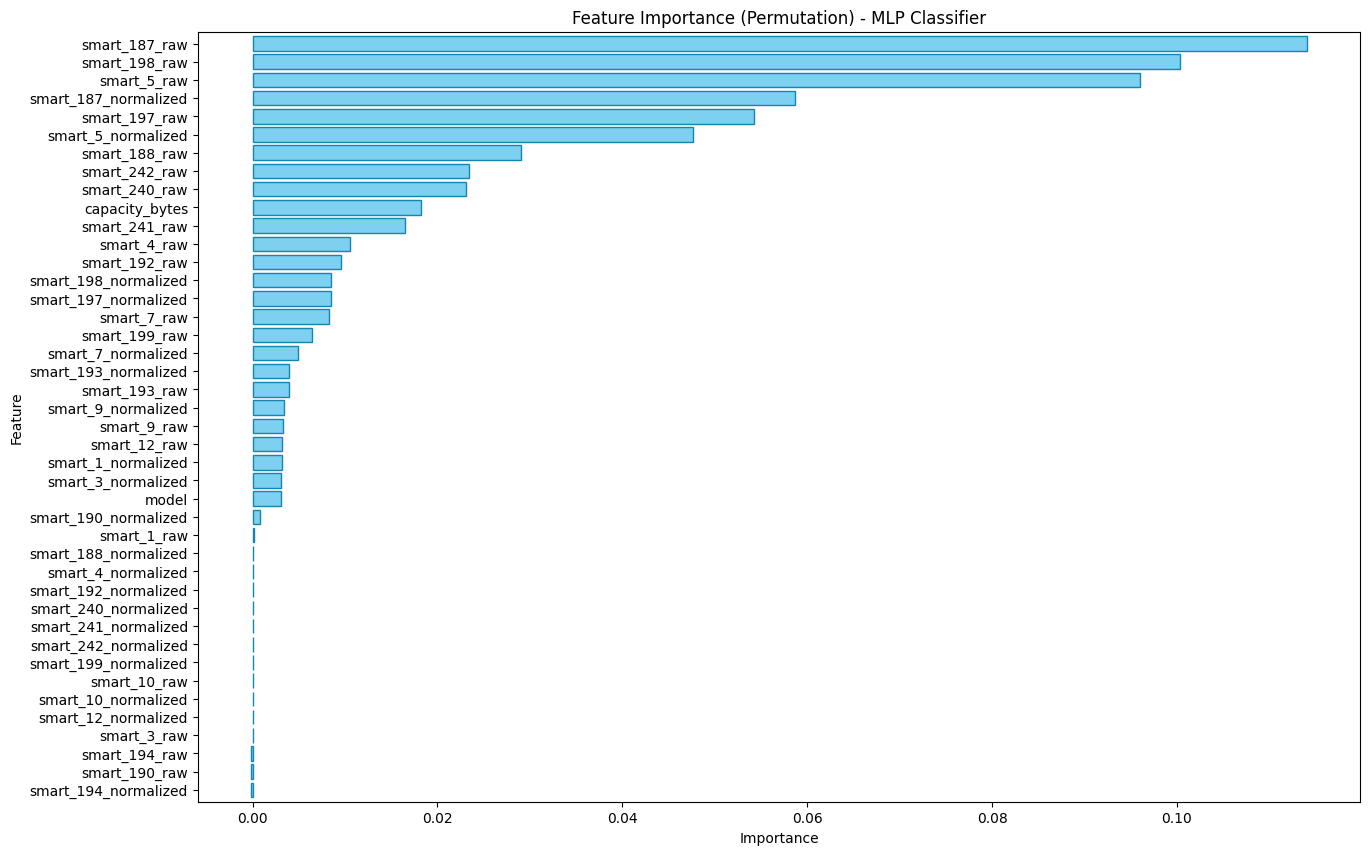

In [73]:
mean_0 = r_0.importances_mean
std_0 = r_0.importances_std
permutation_importances_0 = pd.DataFrame({'mean_importance': mean_0, 'std_importance': std_0}, index=scaled_X_test_0.columns)
permutation_importances_0['feature'] = permutation_importances_0.index
permutation_importances_0.sort_values(by=['mean_importance'], ascending=True, inplace=True)

plt.figure(figsize=(15,10))
fig = permutation_importances_0['mean_importance'].plot.barh(color=[(0.49, 0.816, 0.941)], edgecolor=[(0.071, 0.522, 0.69)], width=0.8, align='center')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Permutation) - MLP Classifier")

print(permutation_importances_0)

0.8819173047725017


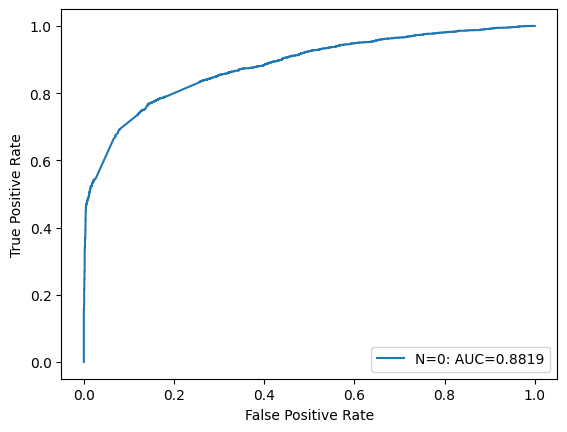

In [45]:
# Calculate AUROC
fpr_0, tpr_0, _ = roc_curve(y_test_0, mlp_model_0.predict_proba(scaled_X_test_0)[:,1])
auc_0 = round(roc_auc_score(y_test_0, mlp_model_0.predict_proba(scaled_X_test_0)[:,1]), 4)
plt.plot(fpr_0,tpr_0,label="N=0: AUC="+str(auc_0))
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

auroc_score_0 = roc_auc_score(y_true=y_test_0, y_score=mlp_model_0.predict_proba(scaled_X_test_0)[:,1])
print(auroc_score_0)

Day minus 1

In [46]:
# Best params: {'solver': 'adam', 'max_iter': 1000, 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'tanh'}

mlp_model_1 = MLPClassifier(solver='adam', max_iter=1000, alpha=0.0001, learning_rate='constant', hidden_layer_sizes=(100,), activation='tanh', random_state=90)
mlp_model_1.fit(scaled_X_train_1, y_train_1)

test_predictions_1 = mlp_model_1.predict(scaled_X_test_1)
cm = confusion_matrix(y_true=y_test_1, y_pred=test_predictions_1)
print(cm)

# Evaluate the model on test set
test_accuracy_1 = mlp_model_1.score(scaled_X_test_1, y_test_1)
print("Test Accuracy:", test_accuracy_1)

[[2247  370]
 [ 726 1947]]
Test Accuracy: 0.7928166351606806


In [47]:
from sklearn.inspection import permutation_importance
r_1 = permutation_importance(mlp_model_1, scaled_X_test_1, y_test_1,
                           n_repeats=30,
                           random_state=0,
                           scoring='roc_auc')

for i in r_1.importances_mean.argsort()[::-1]:
    if r_1.importances_mean[i] - 2 * r_1.importances_std[i] > 0:
        print(f"{scaled_X_test_1.columns[i]:<8}\t\t"
              f"{r_1.importances_mean[i]:.3f}"
              f" +/- {r_1.importances_std[i]:.3f}")

smart_187_raw		0.112 +/- 0.005
smart_5_raw		0.090 +/- 0.004
smart_198_raw		0.083 +/- 0.005
smart_187_normalized		0.061 +/- 0.004
smart_197_raw		0.052 +/- 0.004
smart_5_normalized		0.037 +/- 0.003
smart_188_raw		0.030 +/- 0.002
smart_242_raw		0.027 +/- 0.002
smart_240_raw		0.026 +/- 0.002
smart_241_raw		0.020 +/- 0.002
smart_192_raw		0.016 +/- 0.002
smart_197_normalized		0.014 +/- 0.002
smart_198_normalized		0.014 +/- 0.002
model   		0.011 +/- 0.002
smart_12_raw		0.010 +/- 0.002
smart_7_raw		0.007 +/- 0.002
smart_9_normalized		0.007 +/- 0.001
capacity_bytes		0.005 +/- 0.001
smart_199_raw		0.004 +/- 0.001
smart_4_raw		0.004 +/- 0.001
smart_7_normalized		0.004 +/- 0.001
smart_190_raw		0.003 +/- 0.001
smart_194_raw		0.003 +/- 0.001
smart_9_raw		0.003 +/- 0.001
smart_193_normalized		0.002 +/- 0.001
smart_1_normalized		0.002 +/- 0.001


                      mean_importance  std_importance               feature
smart_4_normalized           0.000000        0.000000    smart_4_normalized
smart_3_raw                  0.000000        0.000000           smart_3_raw
smart_10_raw                 0.000000        0.000000          smart_10_raw
smart_10_normalized          0.000000        0.000000   smart_10_normalized
smart_12_normalized          0.000000        0.000000   smart_12_normalized
smart_241_normalized         0.000000        0.000000  smart_241_normalized
smart_240_normalized         0.000000        0.000000  smart_240_normalized
smart_199_normalized         0.000000        0.000000  smart_199_normalized
smart_242_normalized         0.000000        0.000000  smart_242_normalized
smart_188_normalized         0.000016        0.000098  smart_188_normalized
smart_192_normalized         0.000076        0.000103  smart_192_normalized
smart_1_raw                  0.000085        0.000534           smart_1_raw
smart_194_no

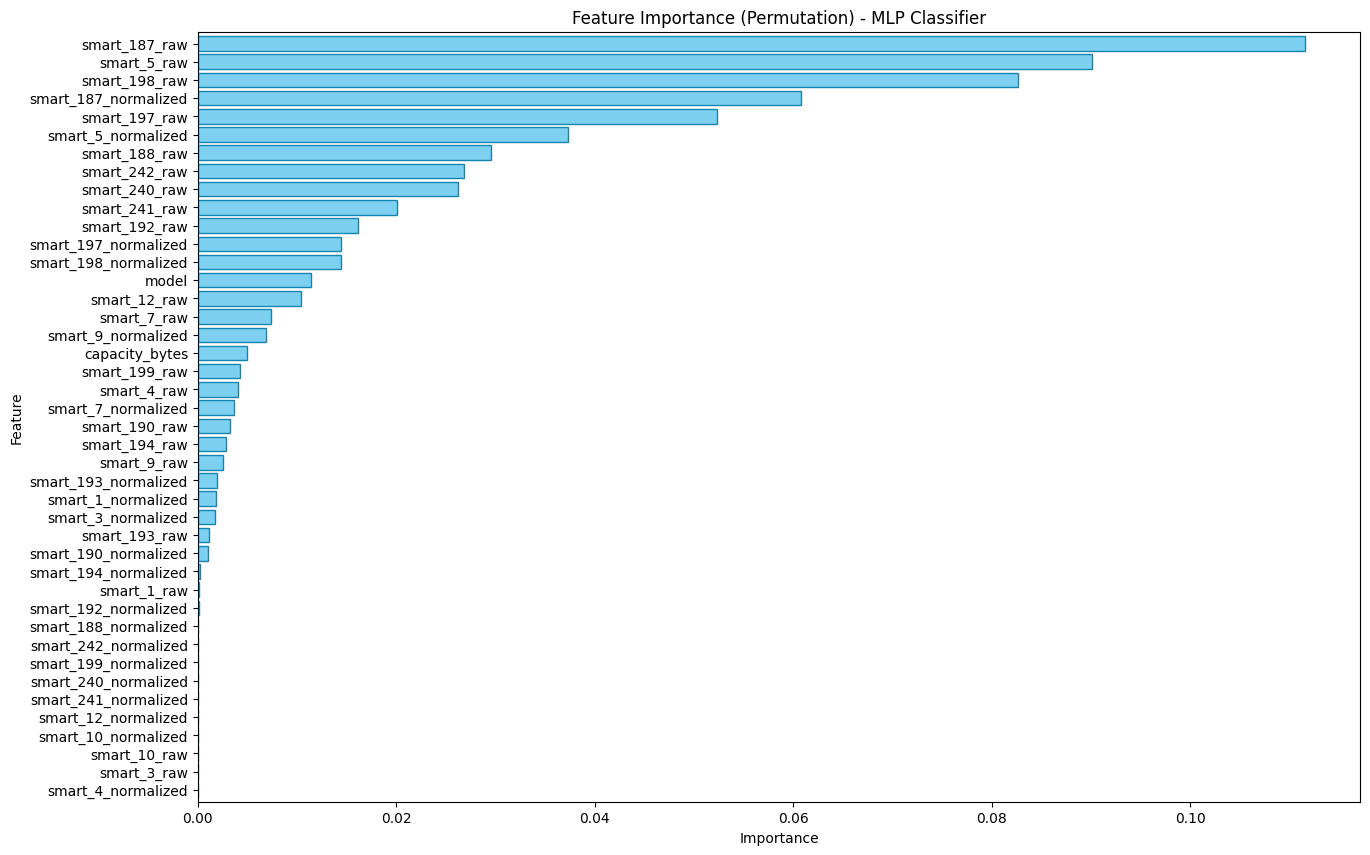

In [74]:
mean_1 = r_1.importances_mean
std_1 = r_1.importances_std
permutation_importances_1 = pd.DataFrame({'mean_importance': mean_1, 'std_importance': std_1}, index=scaled_X_test_1.columns)
permutation_importances_1['feature'] = permutation_importances_1.index
permutation_importances_1.sort_values(by=['mean_importance'], ascending=True, inplace=True)

plt.figure(figsize=(15,10))
fig = permutation_importances_1['mean_importance'].plot.barh(color=[(0.49, 0.816, 0.941)], edgecolor=[(0.071, 0.522, 0.69)], width=0.8, align='center')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Permutation) - MLP Classifier")

print(permutation_importances_1)

0.8619559354709866


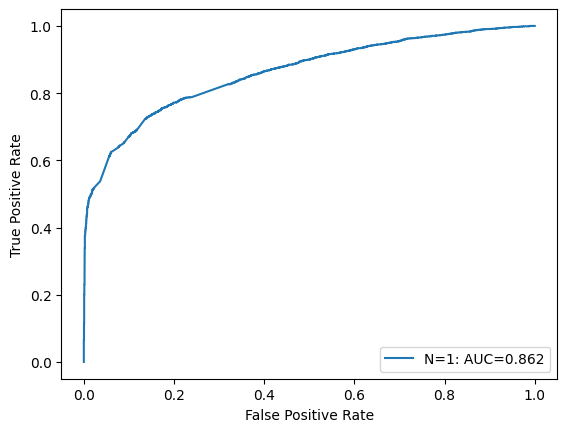

In [49]:
# Calculate AUROC
fpr_1, tpr_1, _ = roc_curve(y_test_1, mlp_model_1.predict_proba(scaled_X_test_1)[:,1])
auc_1 = round(roc_auc_score(y_test_1, mlp_model_1.predict_proba(scaled_X_test_1)[:,1]), 4)
plt.plot(fpr_1,tpr_1,label="N=1: AUC="+str(auc_1))
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

auroc_score_1 = roc_auc_score(y_true=y_test_1, y_score=mlp_model_1.predict_proba(scaled_X_test_1)[:,1])
print(auroc_score_1)

Day minus 2

In [50]:
# Best params: {'solver': 'adam', 'max_iter': 1000, 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'tanh'}

mlp_model_2 = MLPClassifier(solver='adam', max_iter=1000, alpha=0.0001, learning_rate='constant', hidden_layer_sizes=(100,), activation='tanh', random_state=90)
mlp_model_2.fit(scaled_X_train_2, y_train_2)

test_predictions_2 = mlp_model_2.predict(scaled_X_test_2)
cm = confusion_matrix(y_true=y_test_2, y_pred=test_predictions_2)
print(cm)

# Evaluate the model on test set
test_accuracy_2 = mlp_model_2.score(scaled_X_test_2, y_test_2)
print("Test Accuracy:", test_accuracy_2)

[[2223  391]
 [ 734 1940]]
Test Accuracy: 0.7872541603630863


In [51]:
from sklearn.inspection import permutation_importance
r_2 = permutation_importance(mlp_model_2, scaled_X_test_2, y_test_2,
                           n_repeats=30,
                           random_state=0,
                           scoring='roc_auc')

for i in r_2.importances_mean.argsort()[::-1]:
    if r_2.importances_mean[i] - 2 * r_2.importances_std[i] > 0:
        print(f"{scaled_X_test_2.columns[i]:<8}\t\t"
              f"{r_2.importances_mean[i]:.3f}"
              f" +/- {r_2.importances_std[i]:.3f}")

smart_187_raw		0.111 +/- 0.005
smart_5_raw		0.096 +/- 0.005
smart_198_raw		0.089 +/- 0.005
smart_187_normalized		0.043 +/- 0.003
smart_197_raw		0.039 +/- 0.004
smart_240_raw		0.032 +/- 0.002
smart_5_normalized		0.032 +/- 0.003
smart_188_raw		0.031 +/- 0.002
smart_242_raw		0.026 +/- 0.003
smart_241_raw		0.015 +/- 0.002
smart_198_normalized		0.010 +/- 0.002
smart_197_normalized		0.010 +/- 0.002
smart_1_normalized		0.009 +/- 0.001
smart_192_raw		0.008 +/- 0.001
smart_7_raw		0.008 +/- 0.001
capacity_bytes		0.006 +/- 0.001
smart_9_normalized		0.006 +/- 0.001
smart_4_raw		0.005 +/- 0.001
smart_12_raw		0.005 +/- 0.001
smart_199_raw		0.004 +/- 0.001
model   		0.003 +/- 0.001
smart_193_normalized		0.003 +/- 0.001
smart_3_normalized		0.003 +/- 0.001
smart_7_normalized		0.003 +/- 0.001
smart_193_raw		0.002 +/- 0.001
smart_9_raw		0.002 +/- 0.001
smart_190_normalized		0.001 +/- 0.001
smart_190_raw		0.001 +/- 0.000


                      mean_importance  std_importance               feature
smart_1_raw                 -0.000515        0.000338           smart_1_raw
smart_194_normalized        -0.000303        0.000329  smart_194_normalized
smart_4_normalized          -0.000005        0.000023    smart_4_normalized
smart_188_normalized        -0.000002        0.000010  smart_188_normalized
smart_10_raw                 0.000000        0.000000          smart_10_raw
smart_12_normalized          0.000000        0.000000   smart_12_normalized
smart_3_raw                  0.000000        0.000000           smart_3_raw
smart_10_normalized          0.000000        0.000000   smart_10_normalized
smart_242_normalized         0.000000        0.000000  smart_242_normalized
smart_241_normalized         0.000000        0.000000  smart_241_normalized
smart_240_normalized         0.000000        0.000000  smart_240_normalized
smart_199_normalized         0.000000        0.000000  smart_199_normalized
smart_192_no

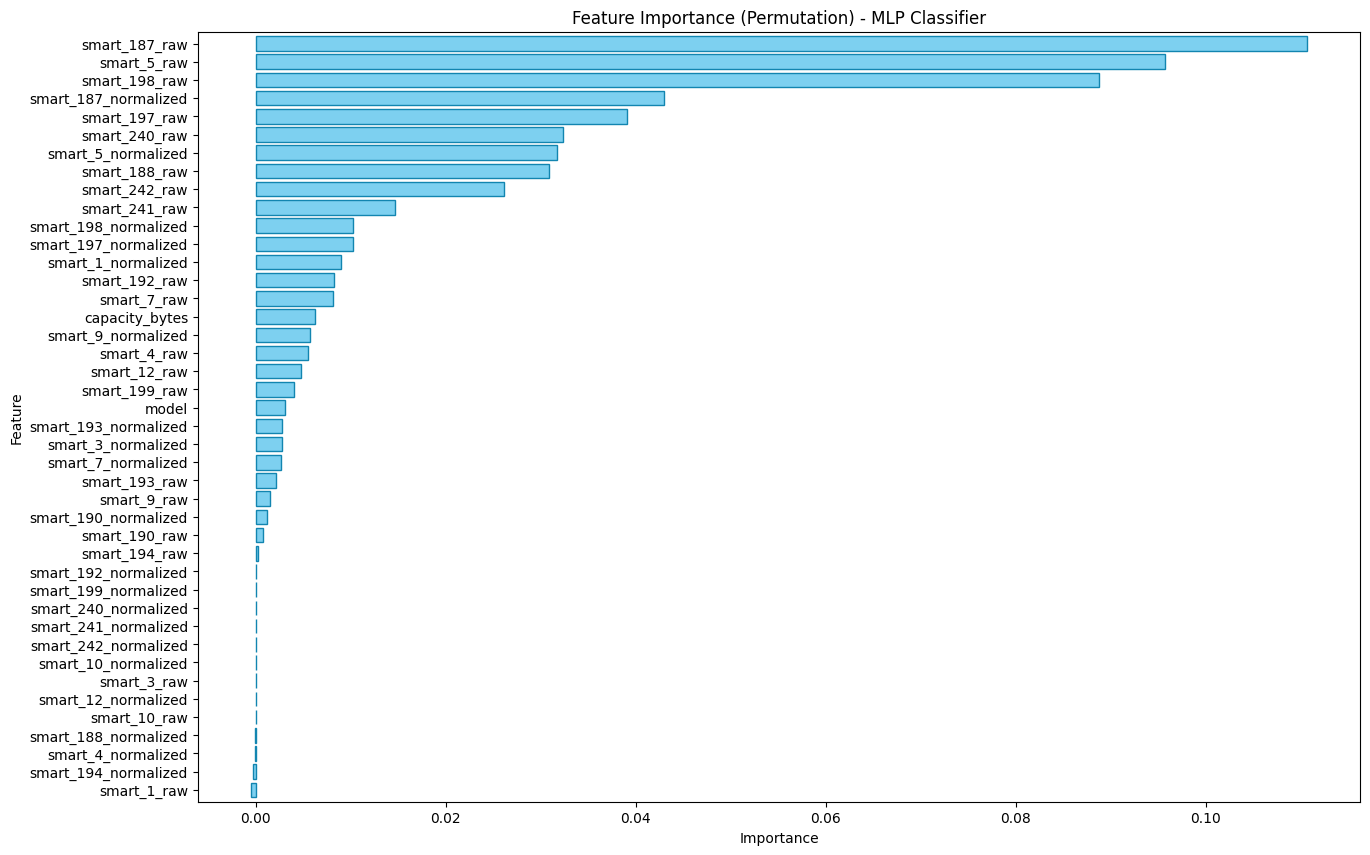

In [75]:
mean_2 = r_2.importances_mean
std_2 = r_2.importances_std
permutation_importances_2 = pd.DataFrame({'mean_importance': mean_2, 'std_importance': std_2}, index=scaled_X_test_2.columns)
permutation_importances_2['feature'] = permutation_importances_2.index
permutation_importances_2.sort_values(by=['mean_importance'], ascending=True, inplace=True)

plt.figure(figsize=(15,10))
fig = permutation_importances_2['mean_importance'].plot.barh(color=[(0.49, 0.816, 0.941)], edgecolor=[(0.071, 0.522, 0.69)], width=0.8, align='center')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Permutation) - MLP Classifier")

print(permutation_importances_2)

0.8657165919200394


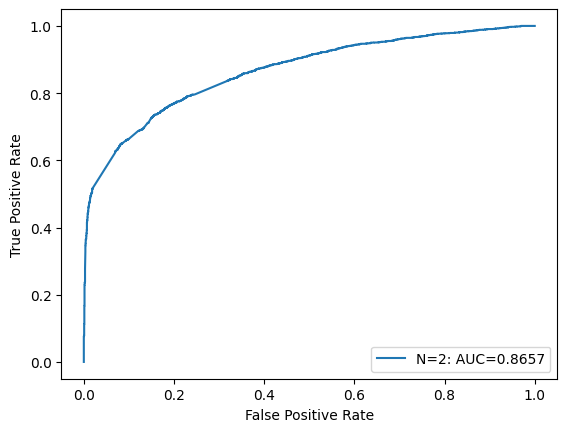

In [53]:
# Calculate AUROC
fpr_2, tpr_2, _ = roc_curve(y_test_2, mlp_model_2.predict_proba(scaled_X_test_2)[:,1])
auc_2 = round(roc_auc_score(y_test_2, mlp_model_2.predict_proba(scaled_X_test_2)[:,1]), 4)
plt.plot(fpr_2,tpr_2,label="N=2: AUC="+str(auc_2))
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

auroc_score_2 = roc_auc_score(y_true=y_test_2, y_score=mlp_model_2.predict_proba(scaled_X_test_2)[:,1])
print(auroc_score_2)

Day minus 7

In [54]:
# Best params: {'solver': 'adam', 'max_iter': 1000, 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'tanh'}

mlp_model_7 = MLPClassifier(solver='adam', max_iter=1000, alpha=0.0001, learning_rate='constant', hidden_layer_sizes=(100,), activation='tanh', random_state=90)
mlp_model_7.fit(scaled_X_train_7, y_train_7)

test_predictions_7 = mlp_model_7.predict(scaled_X_test_7)
cm = confusion_matrix(y_true=y_test_7, y_pred=test_predictions_7)
print(cm)

# Evaluate the model on test set
test_accuracy_7 = mlp_model_7.score(scaled_X_test_7, y_test_7)
print("Test Accuracy:", test_accuracy_7)

[[2169  482]
 [ 829 1835]]
Test Accuracy: 0.7533396048918156


In [55]:
from sklearn.inspection import permutation_importance
r_7 = permutation_importance(mlp_model_7, scaled_X_test_7, y_test_7,
                           n_repeats=30,
                           random_state=0,
                           scoring='roc_auc')

for i in r_7.importances_mean.argsort()[::-1]:
    if r_7.importances_mean[i] - 2 * r_7.importances_std[i] > 0:
        print(f"{scaled_X_test_7.columns[i]:<8}\t\t"
              f"{r_7.importances_mean[i]:.3f}"
              f" +/- {r_7.importances_std[i]:.3f}")

smart_187_raw		0.110 +/- 0.005
smart_5_raw		0.093 +/- 0.005
smart_198_raw		0.076 +/- 0.005
smart_197_raw		0.042 +/- 0.003
smart_242_raw		0.034 +/- 0.003
capacity_bytes		0.029 +/- 0.002
smart_5_normalized		0.028 +/- 0.003
smart_9_normalized		0.027 +/- 0.002
smart_187_normalized		0.027 +/- 0.003
smart_240_raw		0.026 +/- 0.003
smart_188_raw		0.026 +/- 0.002
smart_241_raw		0.024 +/- 0.003
model   		0.020 +/- 0.002
smart_192_raw		0.019 +/- 0.002
smart_12_raw		0.018 +/- 0.002
smart_193_normalized		0.013 +/- 0.001
smart_193_raw		0.013 +/- 0.002
smart_7_raw		0.011 +/- 0.002
smart_4_raw		0.011 +/- 0.002
smart_1_normalized		0.010 +/- 0.002
smart_7_normalized		0.007 +/- 0.001
smart_9_raw		0.006 +/- 0.002
smart_199_raw		0.004 +/- 0.001
smart_190_raw		0.003 +/- 0.001
smart_197_normalized		0.002 +/- 0.001
smart_198_normalized		0.002 +/- 0.001


                      mean_importance  std_importance               feature
smart_190_normalized        -0.001120        0.000865  smart_190_normalized
smart_4_normalized          -0.000012        0.000064    smart_4_normalized
smart_10_raw                 0.000000        0.000000          smart_10_raw
smart_3_raw                  0.000000        0.000000           smart_3_raw
smart_192_normalized         0.000000        0.000000  smart_192_normalized
smart_188_normalized         0.000000        0.000000  smart_188_normalized
smart_12_normalized          0.000000        0.000000   smart_12_normalized
smart_10_normalized          0.000000        0.000000   smart_10_normalized
smart_242_normalized         0.000000        0.000000  smart_242_normalized
smart_241_normalized         0.000000        0.000000  smart_241_normalized
smart_240_normalized         0.000000        0.000000  smart_240_normalized
smart_199_normalized         0.000000        0.000000  smart_199_normalized
smart_194_no

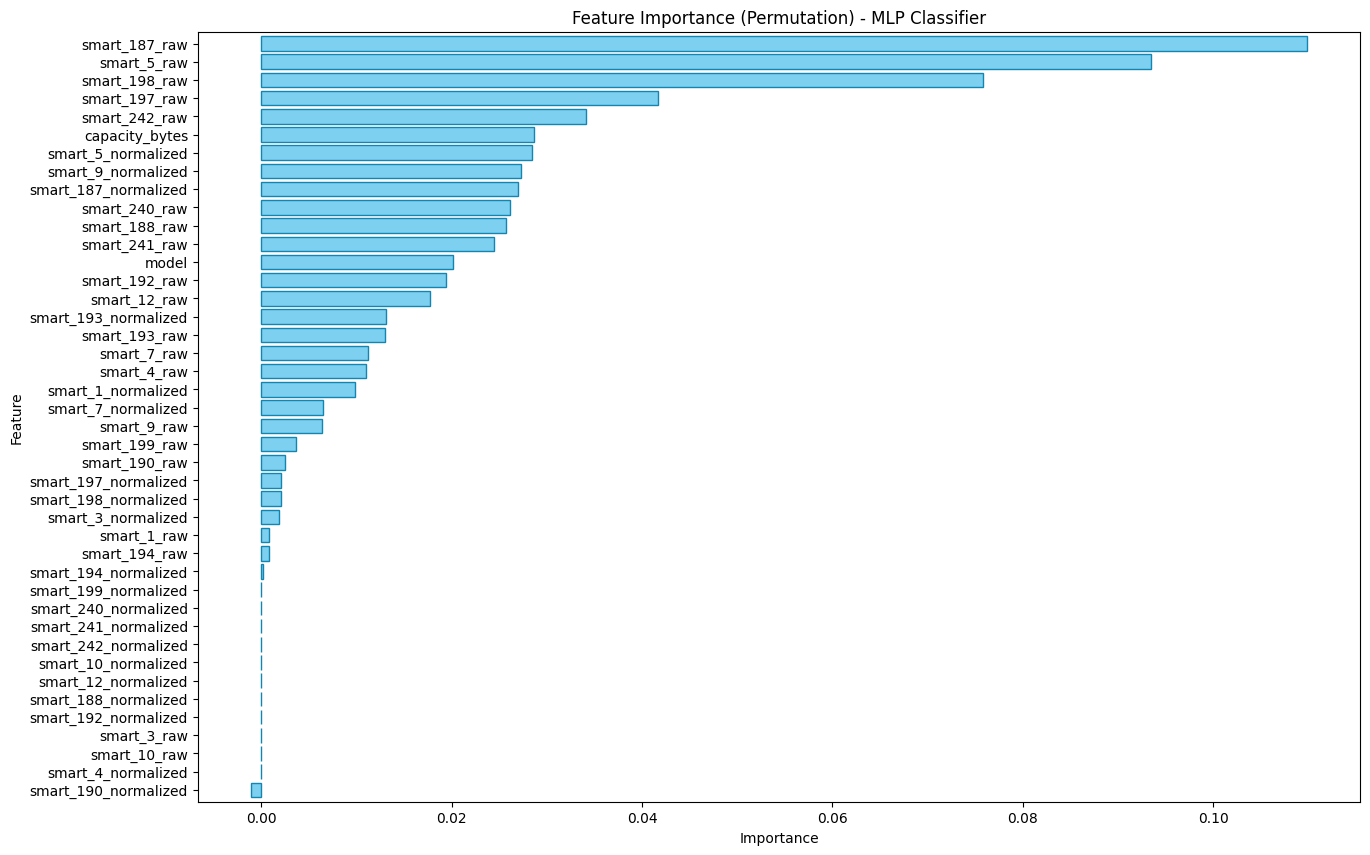

In [76]:
mean_7 = r_7.importances_mean
std_7 = r_7.importances_std
permutation_importances_7 = pd.DataFrame({'mean_importance': mean_7, 'std_importance': std_7}, index=scaled_X_test_7.columns)
permutation_importances_7['feature'] = permutation_importances_7.index
permutation_importances_7.sort_values(by=['mean_importance'], ascending=True, inplace=True)

plt.figure(figsize=(15,10))
fig = permutation_importances_7['mean_importance'].plot.barh(color=[(0.49, 0.816, 0.941)], edgecolor=[(0.071, 0.522, 0.69)], width=0.8, align='center')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Permutation) - MLP Classifier")

print(permutation_importances_7)

0.8261936965256468


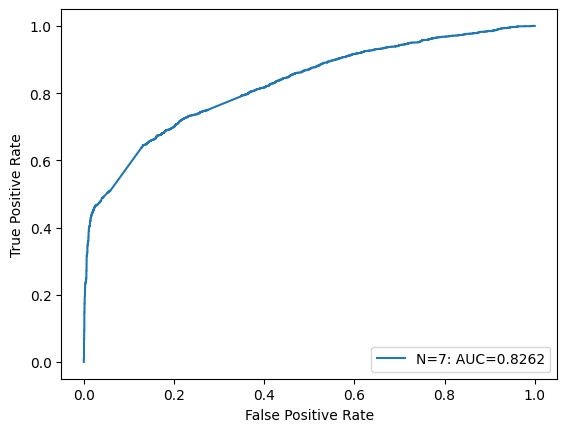

In [57]:
# Calculate AUROC
fpr_7, tpr_7, _ = roc_curve(y_test_7, mlp_model_7.predict_proba(scaled_X_test_7)[:,1])
auc_7 = round(roc_auc_score(y_test_7, mlp_model_7.predict_proba(scaled_X_test_7)[:,1]), 4)
plt.plot(fpr_7,tpr_7,label="N=7: AUC="+str(auc_7))
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

auroc_score_7 = roc_auc_score(y_true=y_test_7, y_score=mlp_model_7.predict_proba(scaled_X_test_7)[:,1])
print(auroc_score_7)

Plot ROC curves for each lookahead window

In [58]:
print(auroc_score_0)
print(auroc_score_1)
print(auroc_score_2)
print(auroc_score_7)

0.8819173047725017
0.8619559354709866
0.8657165919200394
0.8261936965256468


In [59]:
from sklearn.model_selection import cross_val_score

cfs_0 = cross_val_score(mlp_model_0, scaled_X_test_0, y_test_0, cv=5, scoring='roc_auc')
cfs_1 = cross_val_score(mlp_model_1, scaled_X_test_1, y_test_1, cv=5, scoring='roc_auc')
cfs_2 = cross_val_score(mlp_model_2, scaled_X_test_2, y_test_2, cv=5, scoring='roc_auc')
cfs_7 = cross_val_score(mlp_model_7, scaled_X_test_7, y_test_7, cv=5, scoring='roc_auc')

print(f'N=0: AUROC:{cfs_0.mean()}, STD:{cfs_0.std()}, MAX:{cfs_0.max()}, MIN:{cfs_0.min()}')
print(f'N=1: AUROC:{cfs_1.mean()}, STD:{cfs_1.std()}, MAX:{cfs_1.max()}, MIN:{cfs_1.min()}')
print(f'N=2: AUROC:{cfs_2.mean()}, STD:{cfs_2.std()}, MAX:{cfs_2.max()}, MIN:{cfs_2.min()}')
print(f'N=7: AUROC:{cfs_7.mean()}, STD:{cfs_7.std()}, MAX:{cfs_7.max()}, MIN:{cfs_7.min()}')

N=0: AUROC:0.8721126874984897, STD:0.010503159413519432, MAX:0.8861597973435575, MIN:0.8602902916609613
N=1: AUROC:0.8525932170286538, STD:0.013243641939083405, MAX:0.8743767981272672, MIN:0.8335519379567913
N=2: AUROC:0.851688665203099, STD:0.013126278792701436, MAX:0.8634583020016471, MIN:0.8275040997987697
N=7: AUROC:0.825400085740202, STD:0.013305589320553172, MAX:0.8511451732804701, MIN:0.8150483202945238


Text(0, 0.5, 'True Positive Rate')

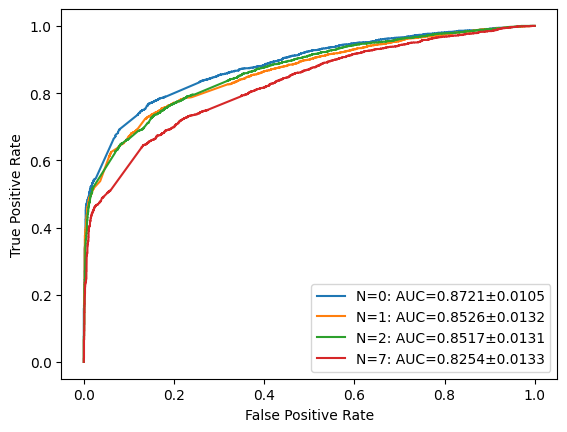

In [60]:
label_0 = f"N=0: AUC={round(cfs_0.mean(), 4)}\u00B1{round(cfs_0.std(), 4)}"
label_1 = f"N=1: AUC={round(cfs_1.mean(), 4)}\u00B1{round(cfs_1.std(), 4)}"
label_2 = f"N=2: AUC={round(cfs_2.mean(), 4):.4f}\u00B1{round(cfs_2.std(), 4)}"
label_7 = f"N=7: AUC={round(cfs_7.mean(), 4)}\u00B1{round(cfs_7.std(), 4)}"

plt.plot(fpr_0,tpr_0,label=label_0)
plt.plot(fpr_1,tpr_1,label=label_1)
plt.plot(fpr_2,tpr_2,label=label_2)
plt.plot(fpr_7,tpr_7,label=label_7)
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [77]:
permutation_importances_0 = permutation_importances_0.rename(columns={'mean_importance':'day_minus_0', 'std_importance':'std_importance_0'})
permutation_importances_1 = permutation_importances_1.rename(columns={'mean_importance':'day_minus_1', 'std_importance':'std_importance_1'})
permutation_importances_2 = permutation_importances_2.rename(columns={'mean_importance':'day_minus_2', 'std_importance':'std_importance_2'})
permutation_importances_7 = permutation_importances_7.rename(columns={'mean_importance':'day_minus_7', 'std_importance':'std_importance_7'})

features = permutation_importances_0.merge(permutation_importances_1, on='feature').merge(permutation_importances_2, on='feature').merge(permutation_importances_7, on='feature')


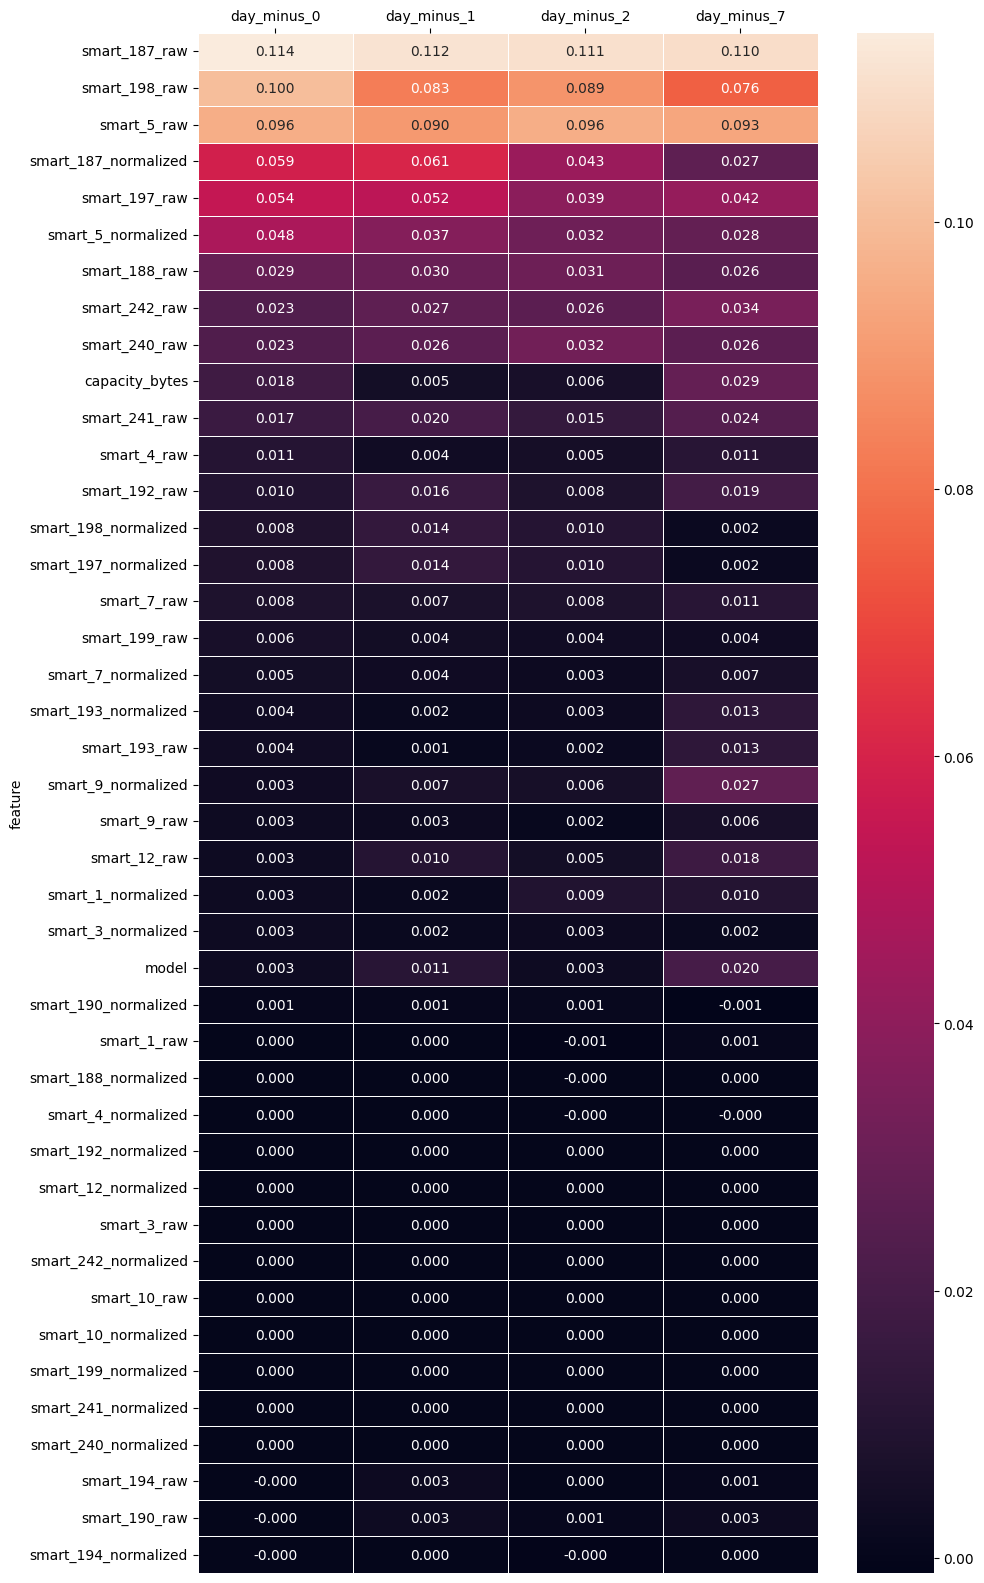

In [78]:
plt.figure(figsize=(10,20))
features.set_index('feature', inplace=True)
features.sort_values('day_minus_0', ascending=False, inplace=True)
heatmap_1 = sns.heatmap(data=features[['day_minus_0', 'day_minus_1', 'day_minus_2', 'day_minus_7']], annot=True, linewidth=.5, fmt=".3f")
heatmap_1.xaxis.tick_top()

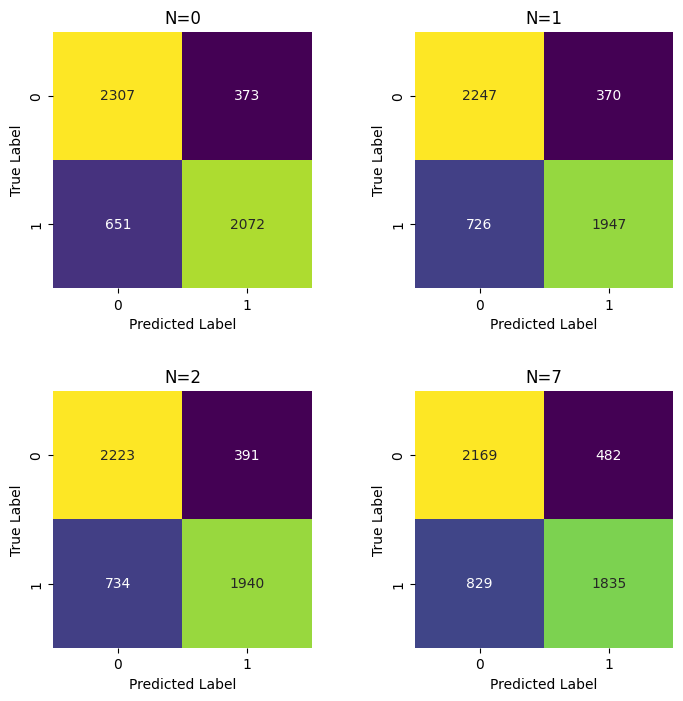

In [82]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

cm_0 = confusion_matrix(y_true=y_test_0, y_pred=test_predictions_0)
cm_1 = confusion_matrix(y_true=y_test_1, y_pred=test_predictions_1)
cm_2 = confusion_matrix(y_true=y_test_2, y_pred=test_predictions_2)
cm_7 = confusion_matrix(y_true=y_test_7, y_pred=test_predictions_7)

ax = fig.add_subplot(2, 2, 1)
sns.heatmap(cm_0, annot=True, fmt='d', cmap='viridis', cbar=False, ax=ax)
ax.title.set_text('N=0')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

ax = fig.add_subplot(2, 2, 2)
sns.heatmap(cm_1, annot=True, fmt='d', cmap='viridis', cbar=False, ax=ax)
ax.title.set_text('N=1')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

ax = fig.add_subplot(2, 2, 3)
sns.heatmap(cm_2, annot=True, fmt='d',  cmap='viridis', cbar=False, ax=ax)
ax.title.set_text('N=2')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

ax = fig.add_subplot(2, 2, 4)
sns.heatmap(cm_7, annot=True, fmt='d',  cmap='viridis', cbar=False, ax=ax)
ax.title.set_text('N=7')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

plt.show()

In [83]:
from sklearn.metrics import classification_report

print(classification_report(y_test_0, test_predictions_0))
print(classification_report(y_test_1, test_predictions_1))
print(classification_report(y_test_2, test_predictions_2))
print(classification_report(y_test_7, test_predictions_7))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82      2680
           1       0.85      0.76      0.80      2723

    accuracy                           0.81      5403
   macro avg       0.81      0.81      0.81      5403
weighted avg       0.81      0.81      0.81      5403

              precision    recall  f1-score   support

           0       0.76      0.86      0.80      2617
           1       0.84      0.73      0.78      2673

    accuracy                           0.79      5290
   macro avg       0.80      0.79      0.79      5290
weighted avg       0.80      0.79      0.79      5290

              precision    recall  f1-score   support

           0       0.75      0.85      0.80      2614
           1       0.83      0.73      0.78      2674

    accuracy                           0.79      5288
   macro avg       0.79      0.79      0.79      5288
weighted avg       0.79      0.79      0.79      5288

              preci

In [84]:
TP_0 = cm_0[1][1]
TN_0 = cm_0[0][0]
FP_0 = cm_0[0][1]
FN_0 = cm_0[1][0]

TP_1 = cm_1[1][1]
TN_1 = cm_1[0][0]
FP_1 = cm_1[0][1]
FN_1 = cm_1[1][0]

TP_2 = cm_2[1][1]
TN_2 = cm_2[0][0]
FP_2 = cm_2[0][1]
FN_2 = cm_2[1][0]

TP_7 = cm_7[1][1]
TN_7 = cm_7[0][0]
FP_7 = cm_7[0][1]
FN_7 = cm_7[1][0]

cm_paramaters_0 = {'tp': TP_0, 'tn': TN_0, 'fp': FP_0, 'fn': FN_0, 'day':'0'}
cm_paramaters_1 = {'tp': TP_1, 'tn': TN_1, 'fp': FP_1, 'fn': FN_1, 'day':'1'}
cm_paramaters_2 = {'tp': TP_2, 'tn': TN_2, 'fp': FP_2, 'fn': FN_2, 'day':'2'}
cm_paramaters_7 = {'tp': TP_7, 'tn': TN_7, 'fp': FP_7, 'fn': FN_7, 'day':'7'}

cm_parameters = pd.DataFrame([cm_paramaters_0, cm_paramaters_1, cm_paramaters_2, cm_paramaters_7])